In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.linear_model import ElasticNet, Lasso, ElasticNetCV,LinearRegression
from sklearn.ensemble import  GradientBoostingRegressor
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test =pd.read_csv('test.csv')

In [3]:
data = pd.concat([train,test])
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [4]:
print(train.shape,test.shape,data.shape)

(1460, 81) (1459, 80) (2919, 81)


In [5]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [6]:
import seaborn as sns
import sklearn_pandas

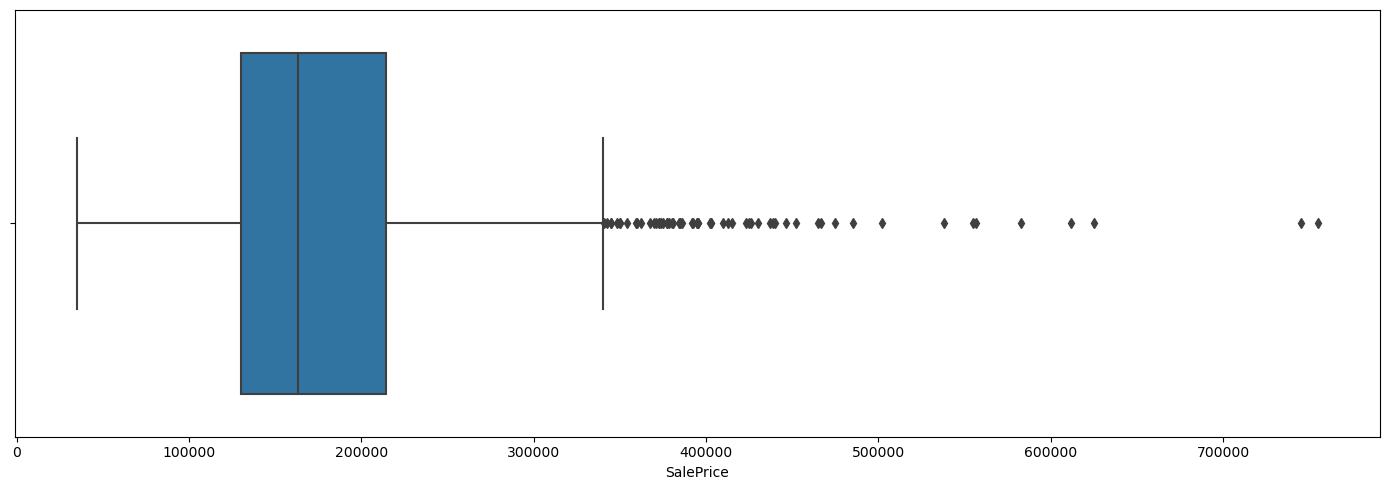

In [7]:
plt.figure(figsize=(14,5))
sns.boxplot(data = train,x='SalePrice')
plt.tight_layout()

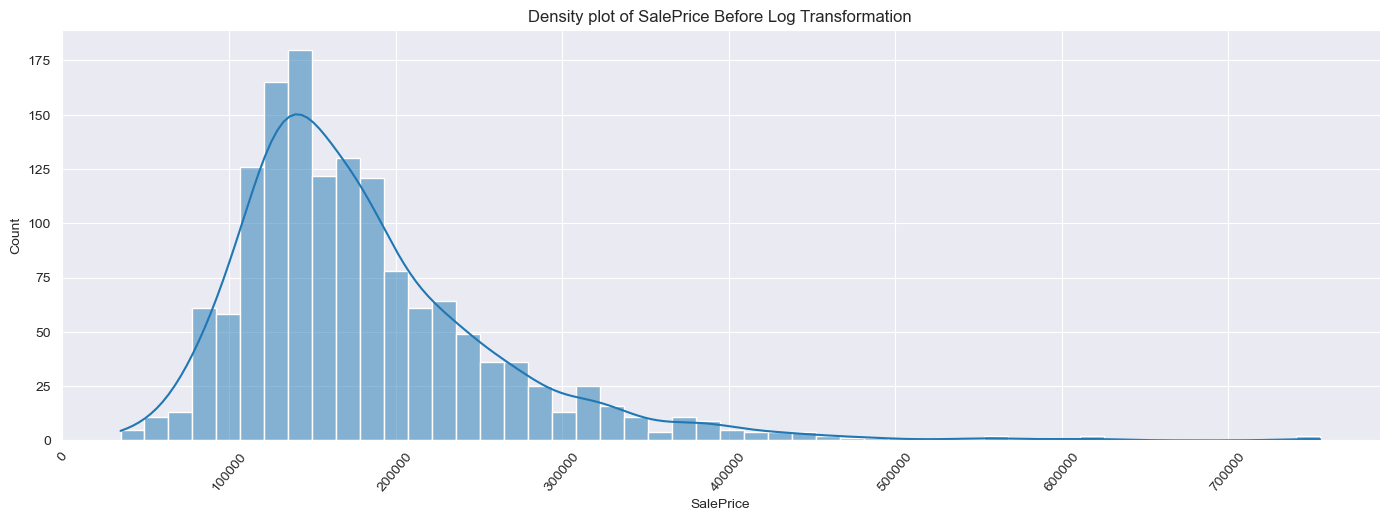

In [8]:
plt.figure(figsize=(14,5))
sns.set_style('darkgrid')
sns.histplot(data= train,x='SalePrice',bins=50,kde=True)
plt.title("Density plot of SalePrice Before Log Transformation")
plt.tight_layout()
plt.xticks(rotation=50)
plt.show()

In [9]:
train.SalePrice.skew()

1.8828757597682129

In [10]:
train['SalePrice'] = np.log1p(train['SalePrice'])

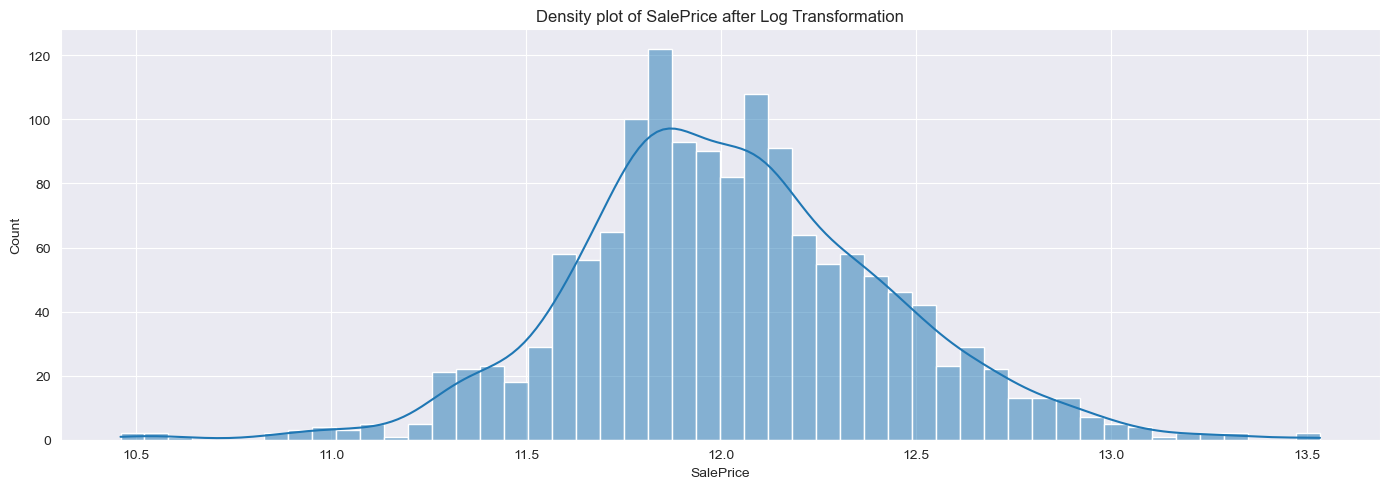

In [11]:
plt.figure(figsize=(14,5))
sns.histplot(train['SalePrice'],kde=True,bins= 50)
plt.title("Density plot of SalePrice after Log Transformation")
plt.tight_layout()
plt.show()

In [12]:
col = train.isna().sum()
col_na = pd.DataFrame({'Column': col.index,'Count':col.values}).sort_values(by='Count',ascending=False)
col_na.head(20)

,Column,Count
72,PoolQC,1453
74,MiscFeature,1406
6,Alley,1369
73,Fence,1179
57,FireplaceQu,690
3,LotFrontage,259
59,GarageYrBlt,81
64,GarageCond,81
58,GarageType,81
60,GarageFinish,81


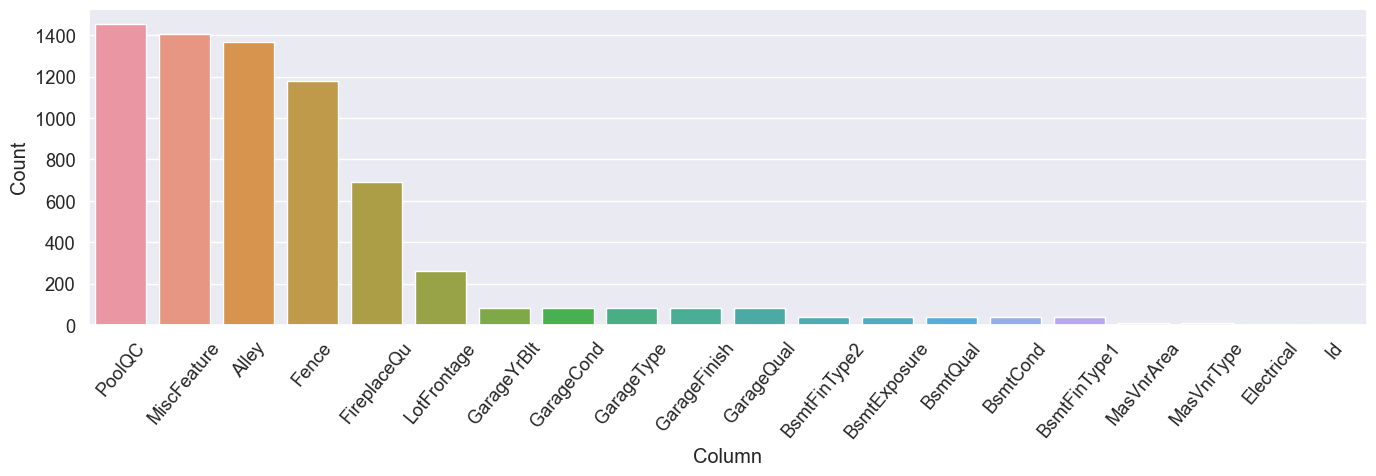

In [13]:
sns.set(font_scale=1.2)
plt.figure(figsize=(14,5))
sns.barplot(data=col_na.head(20),x='Column',y='Count')
plt.xticks(rotation=50)
plt.tight_layout()

In [14]:
col_na['Percent_nan'] = (col_na['Count']/train.shape[0])*100
col_na

,Column,Count,Percent_nan
72,PoolQC,1453,99.520548
74,MiscFeature,1406,96.301370
6,Alley,1369,93.767123
73,Fence,1179,80.753425
57,FireplaceQu,690,47.260274
...,...,...,...
27,ExterQual,0,0.000000
24,Exterior2nd,0,0.000000
23,Exterior1st,0,0.000000
22,RoofMatl,0,0.000000


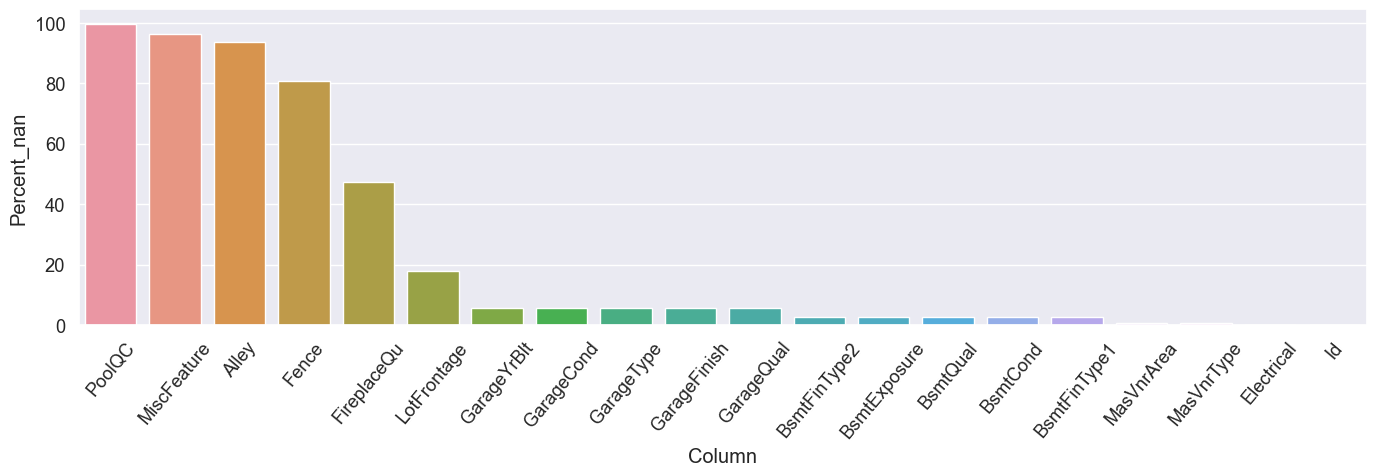

In [15]:
plt.figure(figsize=(14,5))
sns.set(font_scale=1.2)
sns.barplot(data=col_na.head(20),x='Column',y='Percent_nan')
plt.xticks(rotation=50)
plt.tight_layout()

In [16]:
train = train.drop(columns='Id')
test = test.drop(columns='Id')

In [17]:
print(train['Street'].value_counts())
print(train['Utilities'].value_counts())

Pave    1454
Grvl       6
Name: Street, dtype: int64
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64


In [18]:
train = train.drop(columns=['Street','Utilities'])
test = test.drop(columns= ['Street','Utilities'])

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, Normalizer, StandardScaler, OneHotEncoder

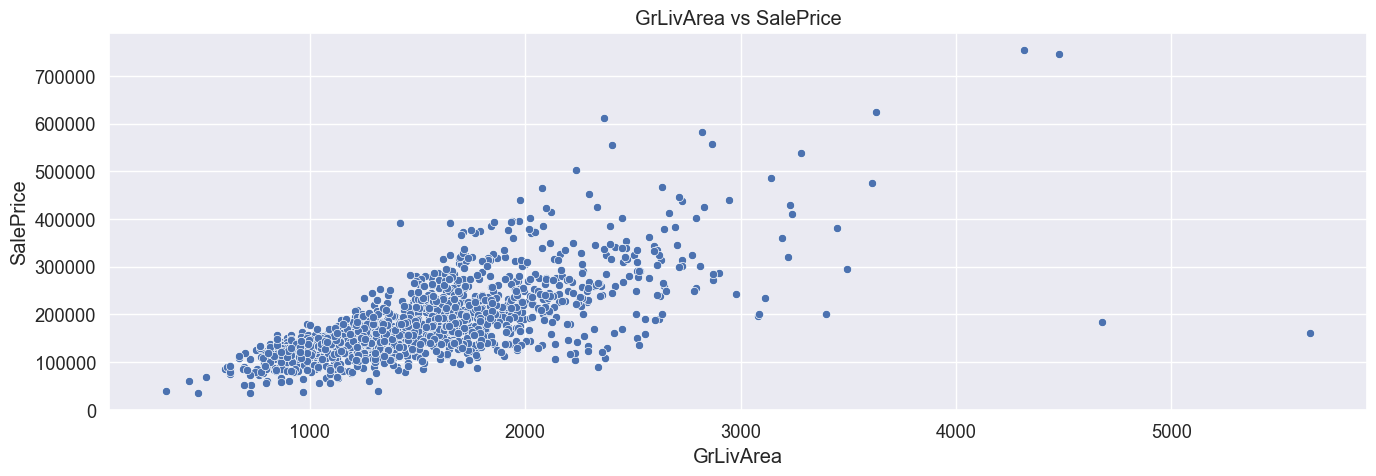

In [20]:
plt.figure(figsize=(14, 5))
sns.set(font_scale=1.2)
sns.scatterplot(data= data, y='SalePrice',x='GrLivArea')
plt.title("GrLivArea vs SalePrice")
plt.tight_layout()
plt.show()

In [21]:
clear_data = data.drop(data[(data['GrLivArea']>4500)].index)

In [22]:
train_ = clear_data.drop(['SalePrice'], axis=1)
all_data = pd.concat([train, test]).reset_index(drop=True)

In [23]:
all_data[all_data['GarageYrBlt']>2017]['GarageYrBlt']

2592    2207.0
Name: GarageYrBlt, dtype: float64

In [24]:
all_data.loc[2592,'GarageYrBlt'] = 2007

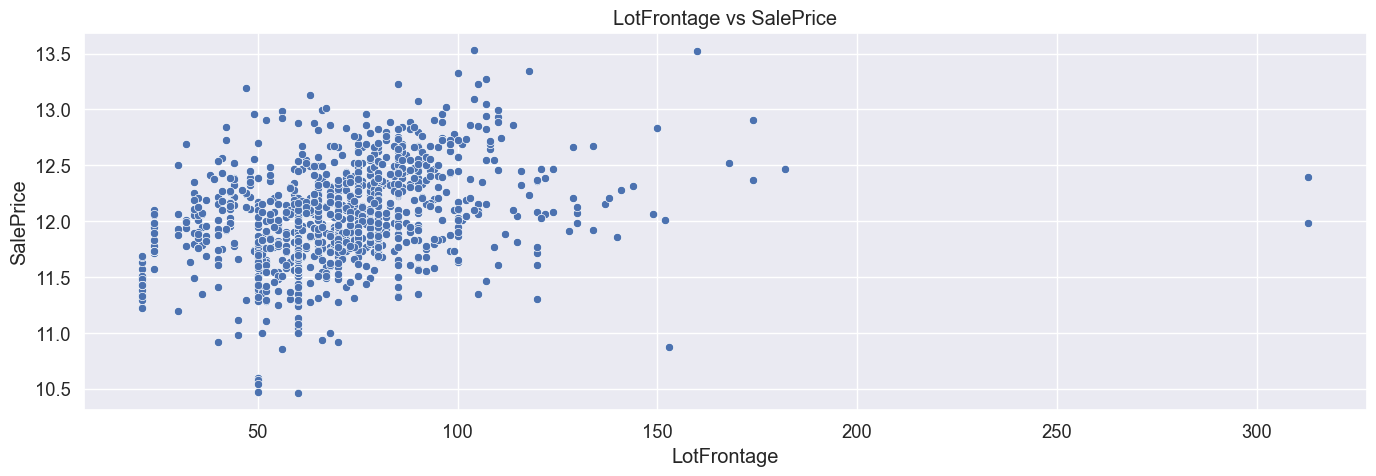

In [25]:
plt.figure(figsize=(14,5))
sns.scatterplot(data = all_data,x='LotFrontage',y='SalePrice')
plt.title("LotFrontage vs SalePrice")
plt.tight_layout()
plt.show()

In [26]:
all_data['Neighborhood']

0       CollgCr
1       Veenker
2       CollgCr
3       Crawfor
4       NoRidge
         ...   
2914    MeadowV
2915    MeadowV
2916    Mitchel
2917    Mitchel
2918    Mitchel
Name: Neighborhood, Length: 2919, dtype: object

In [27]:
nei_lot = all_data.groupby('Neighborhood')['LotFrontage'].agg(['mean','median'])
nei_lot['avg_mean_median'] = (nei_lot['mean']+nei_lot['median'])/2
nei_lot.head().sort_values(by='avg_mean_median',ascending =False)

,mean,median,avg_mean_median
Neighborhood,,,
ClearCr,88.150000,80.5,84.325000
BrkSide,55.789474,51.0,53.394737
Blmngtn,46.900000,43.0,44.950000
Blueste,27.300000,24.0,25.650000
BrDale,21.500000,21.0,21.250000


In [28]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [29]:
def convert_to_string(df, columns):
    df[columns] = df[columns].astype(str)
    return df


num_to_categ_features = ['MSSubClass', 'OverallCond']
all_data = convert_to_string(all_data, columns = num_to_categ_features)

In [30]:
num_features = all_data.select_dtypes(include=['int64','float64']).columns
num_features_to_constant = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', "MasVnrArea"] 
num_features_to_median = [feature for feature in num_features if feature not in num_features_to_constant + ["SalePrice"]]

In [31]:
numeric_features_median = sklearn_pandas.gen_features(columns=[num_features_to_median], 
                                               classes=[{'class': SimpleImputer, 
                                                         'strategy': 'median', 
                                                         'missing_values' : np.nan}])

numeric_features_zero = sklearn_pandas.gen_features(columns=[num_features_to_constant], 
                                               classes=[{'class': SimpleImputer, 
                                                         'strategy': 'constant',
                                                         'fill_value' : 0, 
                                                         'missing_values' : np.nan}])

missing_val_imputer = sklearn_pandas.DataFrameMapper(numeric_features_median + numeric_features_zero)

In [32]:
imputed_median = missing_val_imputer.fit(all_data)
imputed_features = imputed_median.transform(all_data)
imputed_df = pd.DataFrame(imputed_features, index=all_data.index, columns=num_features_to_median + num_features_to_constant)

In [33]:
imputed_df.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,MasVnrArea
0,65.0,8450.0,7.0,2003.0,2003.0,150.0,856.0,856.0,854.0,0.0,...,0.0,0.0,0.0,2.0,2008.0,706.0,0.0,1.0,0.0,196.0
1,80.0,9600.0,6.0,1976.0,1976.0,284.0,1262.0,1262.0,0.0,0.0,...,0.0,0.0,0.0,5.0,2007.0,978.0,0.0,0.0,1.0,0.0
2,68.0,11250.0,7.0,2001.0,2002.0,434.0,920.0,920.0,866.0,0.0,...,0.0,0.0,0.0,9.0,2008.0,486.0,0.0,1.0,0.0,162.0
3,60.0,9550.0,7.0,1915.0,1970.0,540.0,756.0,961.0,756.0,0.0,...,0.0,0.0,0.0,2.0,2006.0,216.0,0.0,1.0,0.0,0.0
4,84.0,14260.0,8.0,2000.0,2000.0,490.0,1145.0,1145.0,1053.0,0.0,...,0.0,0.0,0.0,12.0,2008.0,655.0,0.0,1.0,0.0,350.0


In [34]:
cat_feats = all_data.select_dtypes(include=['object']).columns
cat_feats

Index(['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallCond', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [35]:
none_conversion = [("MasVnrType","None"),
                  ("BsmtQual","NA"), 
                  ("Electrical", "SBrkr"),
                  ("BsmtCond","TA"),
                  ("BsmtExposure","No"),
                  ("BsmtFinType1","No"),
                  ("BsmtFinType2","No"),
                  ("CentralAir","N"),
                  ("Condition1","Norm"), 
                  ("Condition2","Norm"),
                  ("ExterCond","TA"),
                  ("ExterQual","TA"), 
                  ("FireplaceQu","NA"),
                  ("Functional","Typ"),
                  ("GarageType","No"), 
                  ("GarageFinish","No"), 
                  ("GarageQual","NA"), 
                  ("GarageCond","NA"), 
                  ("HeatingQC","TA"), 
                  ("KitchenQual","TA"), 
                  ("Functional","Typ"), 
                  ("GarageType","No"), 
                  ("GarageFinish","No"), 
                  ("GarageQual","No"), 
                  ("GarageCond","No"), 
                  ("HeatingQC","TA"), 
                  ("KitchenQual","TA"),
                  ("MSZoning", "None"),
                  ("Exterior1st", "VinylSd"), 
                  ("Exterior2nd", "VinylSd"), 
                  ("SaleType", "WD")]


In [91]:
def none_transform(df, conversion_list):
    for col, new_str in conversion_list:
        df.loc[:, col] = df.loc[:, col].fillna(new_str)
    return df


In [37]:
all_data = none_transform(all_data, none_conversion)
len(all_data.columns)

78

In [38]:
numeric_features = [feat for feat in num_features if feat not in ['SalePrice']] 

In [39]:
skewed_features = all_data[num_features].apply(lambda x: x.dropna().skew())
skewed_features = skewed_features[skewed_features > 0.5].index
print("\nHighly skewed features: \n\n{}".format(skewed_features.tolist()))


Highly skewed features: 

['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


In [40]:
all_data[skewed_features] = np.log1p(all_data[skewed_features])
test[skewed_features] = np.log1p(test[skewed_features])

In [41]:
class OrderedLabelTransformer(BaseEstimator, TransformerMixin):
    orderDict = {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
    
    @staticmethod
    def get_dict(X):
        FirstDict = {"Po" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
        SecondDict = {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
        ThirdDict = {"NA" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
        for d in [FirstDict, SecondDict, ThirdDict]:
            if set(X) == set(d): 
                return d
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def get_label(t):
            return self.orderDict[t]
        return np.array([get_label(n) for n in X])

In [42]:
class NeighborhoodTransformer(BaseEstimator, TransformerMixin):
    neighborhoodsmap = {'StoneBr' : 2, 'NridgHt' : 2, 'NoRidge': 2, 
                        'MeadowV' : 0, 'IDOTRR' : 0, 'BrDale' : 0 ,
                        'CollgCr': 1, 'Veenker' : 1, 'Crawfor' : 1,
                        'Mitchel' : 1, 'Somerst' : 1, 'NWAmes' : 1,
                        'OldTown' : 1, 'BrkSide' : 1, 'Sawyer' : 1, 
                        'NAmes' : 1, 'SawyerW' : 1, 'Edwards' : 1,
                        'Timber' : 1, 'Gilbert' : 1, 'ClearCr' : 1,
                        'NPkVill' : 1, 'Blmngtn' : 1, 'SWISU' : 1,
                        'Blueste': 1}

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def get_label(t):
            return self.neighborhoodsmap[t]
        return np.array([get_label(n) for [n] in X])

In [43]:
order_feats = ["ExterQual", "ExterCond", "HeatingQC", "KitchenQual", "BsmtQual","BsmtCond", "FireplaceQu", "GarageQual", "GarageCond"]
original_features_df = all_data[order_feats + ['Neighborhood']]
order_features = sklearn_pandas.gen_features(order_feats, [OrderedLabelTransformer])
neighb_features = [(['Neighborhood'], [NeighborhoodTransformer()])]

In [44]:
label_encoder = sklearn_pandas.DataFrameMapper(neighb_features + order_features)

In [45]:
cols = ["Neighborhood"] + order_feats
transformed_feats = label_encoder.fit_transform(all_data)
transformed_df = pd.DataFrame(transformed_feats, index=all_data.index, columns=cols)
original_features_df.shape

(2919, 10)

In [46]:
rest_features = set(pd.concat([imputed_df, original_features_df],axis=1).columns).symmetric_difference(set(all_data.columns))
rest_features_df = all_data[list(rest_features)]
all_data = pd.concat([imputed_df, original_features_df, rest_features_df],axis=1)
all_data.shape

(2919, 78)

In [47]:
all_data["TotalSqrtFeet"] = all_data["GrLivArea"] + all_data["TotalBsmtSF"]
test["TotalSqrtFeet"] = test["GrLivArea"] + test["TotalBsmtSF"]

all_data["TotalBaths"] = all_data["BsmtFullBath"] + (all_data["BsmtHalfBath"]  * .5) + all_data["FullBath"] + (all_data["HalfBath"]* .5)
test["TotalBaths"] = test["BsmtFullBath"] + (test["BsmtHalfBath"]  * .5) + test["FullBath"] + (test["HalfBath"]* .5)

In [48]:
all_data['Isgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

all_data['Isfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

all_data['Ispool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

all_data['Issecondfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

all_data['IsOpenPorch'] = all_data['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)

all_data['IsWoodDeck'] = all_data['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)

In [49]:
y_train = train['SalePrice']

In [50]:
all_data = all_data.drop(["SalePrice"], axis = 1)

hot_one_features = pd.get_dummies(all_data).reset_index(drop=True)
hot_one_features.shape

(2919, 324)

In [51]:
all_data = pd.concat([transformed_df, hot_one_features],axis=1)

In [52]:
train_preprocessed = all_data.iloc[:len(train),:]
test_preprocessed = all_data.iloc[len(train_preprocessed):,:]
print(len(test_preprocessed) == len(test))

True


In [53]:
X_train = train_preprocessed
X_test = test_preprocessed

In [54]:
def rmse(model):
    n_folds=5
    kfold = KFold(n_folds, random_state=42, shuffle=True).get_n_splits(X_train)
    rmse_score = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = kfold, verbose = -1, n_jobs=-1))
    return(np.mean(rmse_score))

In [55]:
X_train.shape,y_train.shape,X_test.shape

((1460, 334), (1460,), (1459, 334))

In [56]:
from sklearn.metrics import mean_squared_error,accuracy_score

In [57]:
def rmse(model):
    n_folds = 5
    kfold = KFold(n_folds, random_state=42, shuffle=True).get_n_splits(X_train)
    rmse_score = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kfold, n_jobs=-1))
    return np.mean(rmse_score)

In [58]:
lr_model = make_pipeline(RobustScaler(), LinearRegression())
lr_model.fit(X_train,y_train)
y_train_pred = lr_model.predict(X_train)
mse_train = round(mean_squared_error(y_train_pred,y_train),5)
rmse_lr = round(rmse(lr_model), 5)
print('MSE for Linear Regression is :',mse_train)
print('RMSE for Linear Regression is :',rmse_lr)

MSE for Linear Regression is : 0.00858
RMSE for Linear Regression is : 0.16004


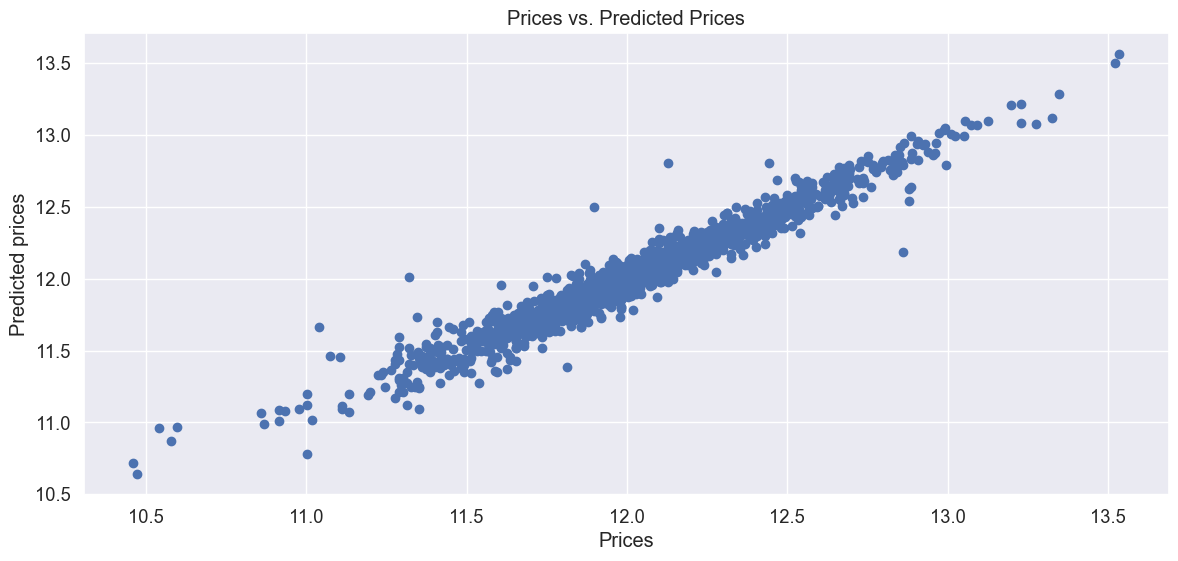

In [59]:
plt.figure(figsize=(14,6))
plt.scatter(y_train, y_train_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs. Predicted Prices")
plt.show()

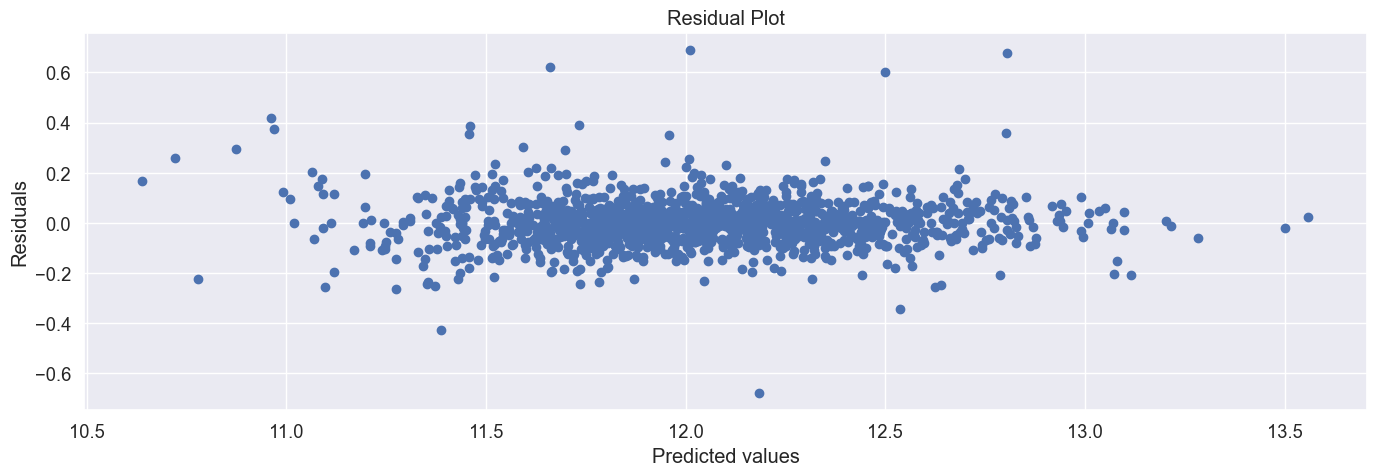

In [60]:
plt.figure(figsize=(14,5))
plt.scatter(y_train_pred,y_train_pred - y_train)
plt.title("Residual Plot")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.tight_layout()


In [61]:
ls_model = make_pipeline(RobustScaler(),LassoCV(alphas=[0.0005],random_state=0,cv=10))
ls_model.fit(X_train,y_train)
y_train_pred = ls_model.predict(X_train)
mse_train = round(mean_squared_error(y_train_pred,y_train),5)
rmse_lasso = round(rmse(ls_model),5)
print('MSE for Linear Regression is :',mse_train)
print('RMSE for Linear Regression is :',rmse_lasso)

MSE for Linear Regression is : 0.01133
RMSE for Linear Regression is : 0.1337


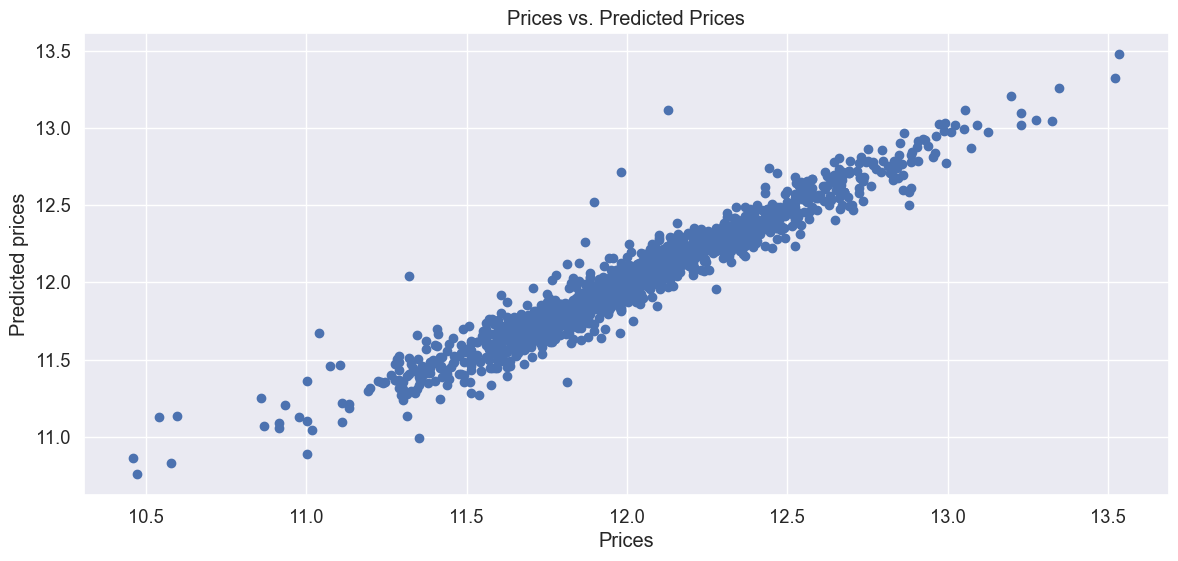

In [62]:
plt.figure(figsize=(14,6))
plt.scatter(y_train, y_train_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs. Predicted Prices")
plt.show()

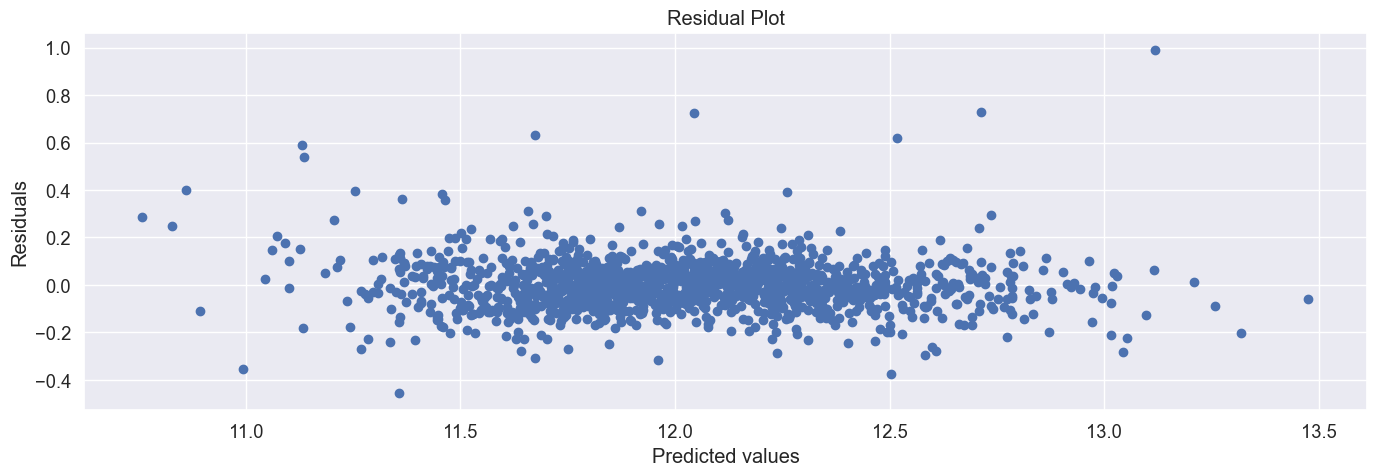

In [63]:
plt.figure(figsize=(14,5))
plt.scatter(y_train_pred,y_train_pred - y_train)
plt.title("Residual Plot")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.tight_layout()

In [64]:
gbr = GradientBoostingRegressor(random_state=0)
param_grid = {'n_estimators': [3400],
              'max_features': [13],
              'max_depth': [5],
              'learning_rate': [0.01],
              'subsample': [0.8],
             'random_state' : [5]}
gb_model = GridSearchCV(estimator=gbr, param_grid=param_grid, n_jobs=1, cv=5)
gb_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
             n_jobs=1,
             param_grid={'learning_rate': [0.01], 'max_depth': [5],
                         'max_features': [13], 'n_estimators': [3400],
                         'random_state': [5], 'subsample': [0.8]})

In [65]:
y_train_pred = gb_model.predict(X_train)
mse_train = round(mean_squared_error(y_train_pred,y_train),5)
rmse_gb = round(rmse(gb_model),5)
print('MSE for Linear Regression is :',mse_train)
print('RMSE for Linear Regression is :',rmse_gb)

MSE for Linear Regression is : 0.0007
RMSE for Linear Regression is : 0.11782


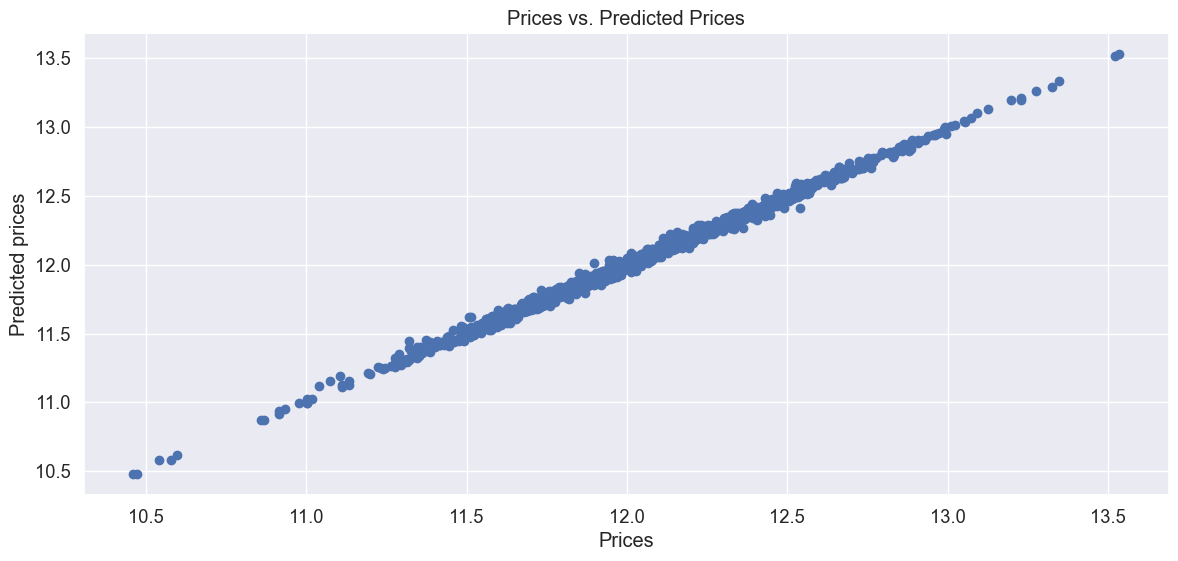

In [66]:
plt.figure(figsize=(14,6))
plt.scatter(y_train, y_train_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs. Predicted Prices")
plt.show()

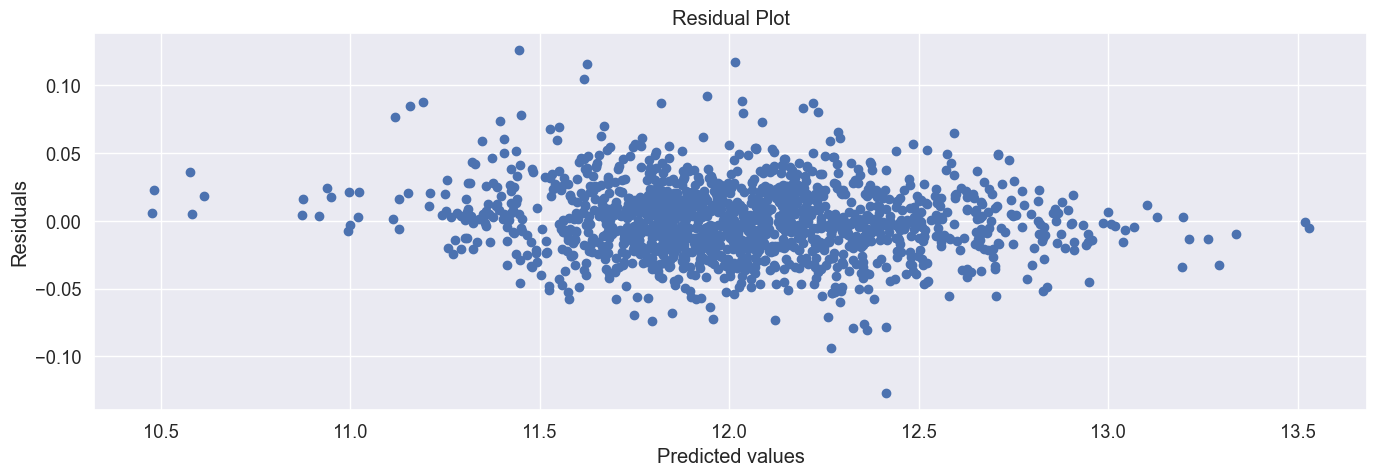

In [67]:
plt.figure(figsize=(14,5))
plt.scatter(y_train_pred,y_train_pred - y_train)
plt.title("Residual Plot")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.tight_layout()

In [68]:
xgbreg = xgb.XGBRegressor(seed=0)
param_grid2 = {'n_estimators': [2500], 
              'learning_rate': [0.03],
              'max_depth': [3],
              'subsample': [0.8],
              'colsample_bytree': [0.45]}
    
xgb_model = GridSearchCV(estimator=xgbreg, param_grid=param_grid2, n_jobs=1, cv=10)
xgb_model.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None,...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=1,
             param_grid={'colsample_bytree': [0.45], 'learning_rate': [0.03],
                         'max_depth': [3], 'n_estimators': [2500],
                         'subsample': [0.8]})

In [69]:
y_train_pred = xgb_model.predict(X_train)
mse_train = round(mean_squared_error(y_train_pred,y_train),5)
rmse_xgb = round(rmse(xgb_model),5)
print('MSE for Linear Regression is :',mse_train)
print('RMSE for Linear Regression is :',rmse_xgb)

MSE for Linear Regression is : 0.0009
RMSE for Linear Regression is : 0.118


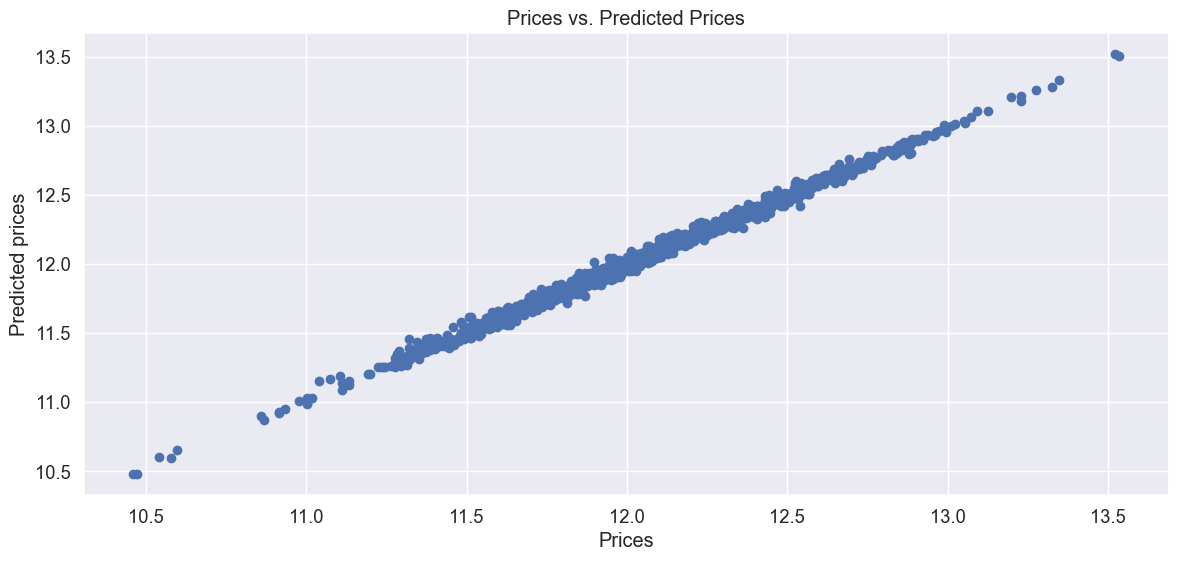

In [70]:
plt.figure(figsize=(14,6))
plt.scatter(y_train, y_train_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs. Predicted Prices")
plt.show()

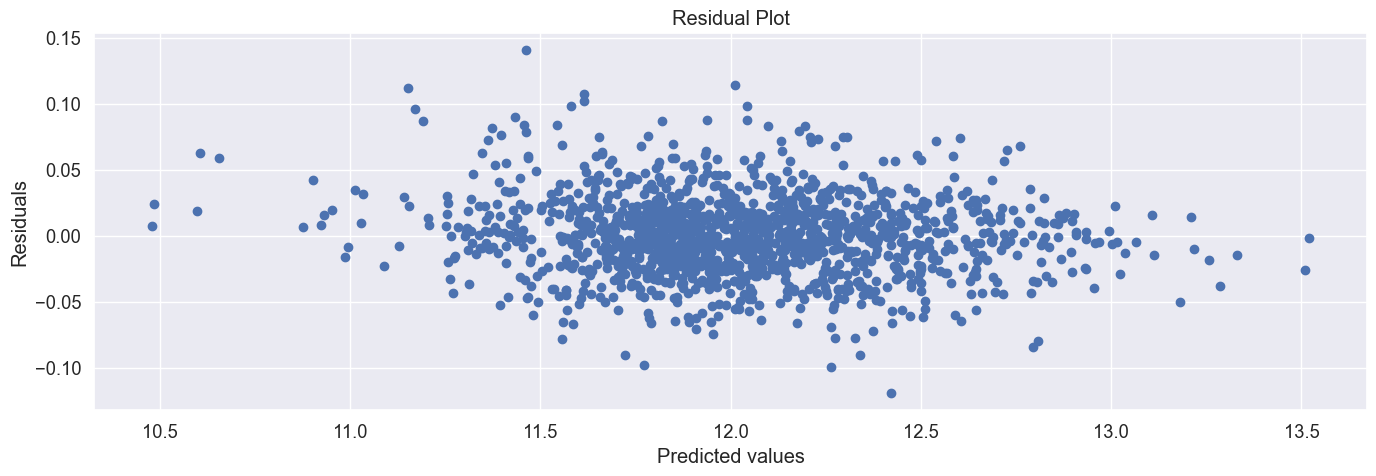

In [71]:
plt.figure(figsize=(14,5))
plt.scatter(y_train_pred,y_train_pred - y_train)
plt.title("Residual Plot")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.tight_layout()

In [72]:
en_model = ElasticNetCV(alphas = [0.0005], 
                        l1_ratio = [.9], 
                        random_state = 0,
                        cv=10)
en_model.fit(X_train,y_train)

ElasticNetCV(alphas=[0.0005], cv=10, l1_ratio=[0.9], random_state=0)

In [73]:
y_train_pred = xgb_model.predict(X_train)
mse_train = round(mean_squared_error(y_train_pred,y_train),5)
rmse_en = round(rmse(en_model),5)
print('MSE for Linear Regression is :',mse_train)
print('RMSE for Linear Regression is :',rmse_en)

MSE for Linear Regression is : 0.0009
RMSE for Linear Regression is : 0.13432


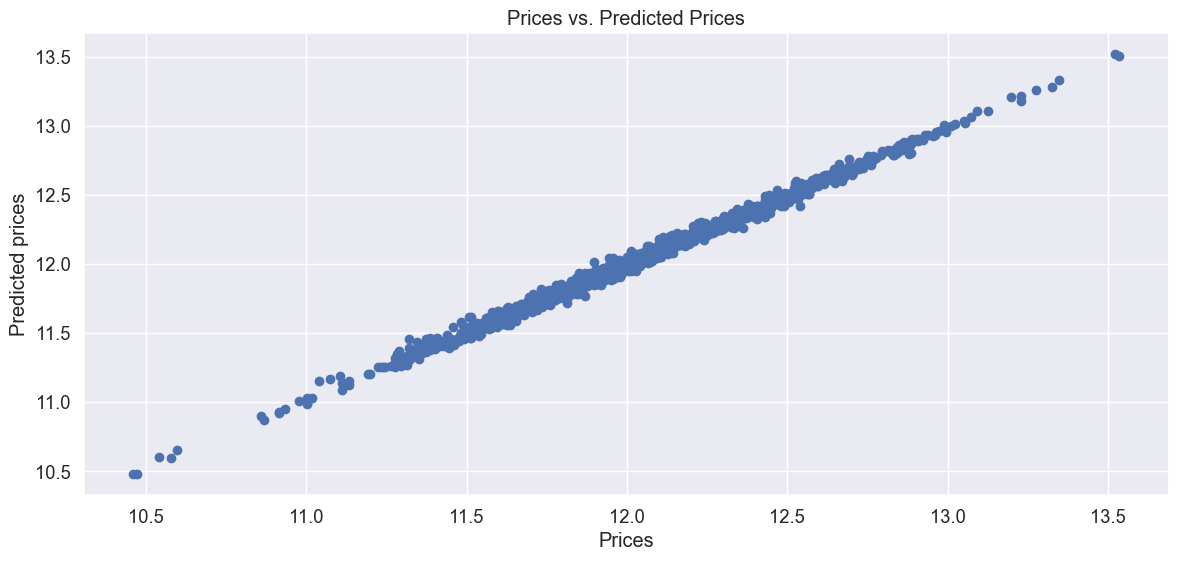

In [74]:
plt.figure(figsize=(14,6))
plt.scatter(y_train, y_train_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs. Predicted Prices")
plt.show()

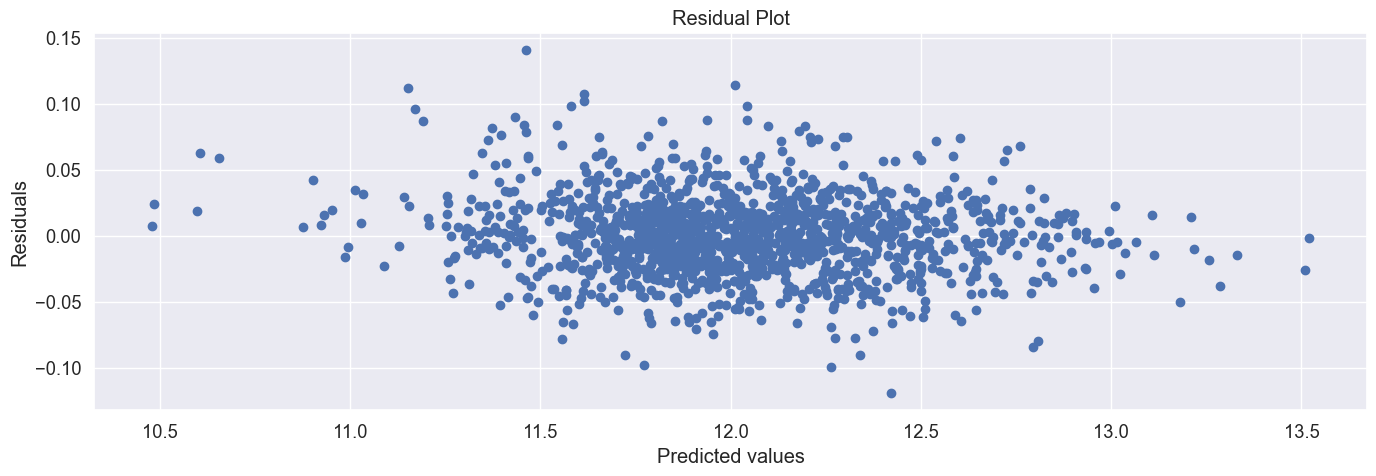

In [75]:
plt.figure(figsize=(14,5))
plt.scatter(y_train_pred,y_train_pred - y_train)
plt.title("Residual Plot")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.tight_layout()

In [76]:
lgb_model = lgb.LGBMRegressor(objective='regression', num_leaves=5,
                              learning_rate=0.05, n_estimators=4000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
lgb_model.fit(X_train,y_train)

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_wei

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              feature_fraction=0.2, feature_fraction_seed=9, learning_rate=0.05,
              max_bin=55, min_data_in_leaf=6, min_sum_hessian_in_leaf=11,
              n_estimators=4000, num_leaves=5, objective='regression')

In [77]:
y_train_pred = lgb_model.predict(X_train)
mse_train = round(mean_squared_error(y_train_pred,y_train),5)
rmse_lgb = round(np.sqrt(mean_squared_error(y_train_pred,y_train)),5)
print('MSE for Linear Regression is :',mse_train)
print('RMSE for Linear Regression is :',rmse_lgb)

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
MSE for Linear Regression is : 0.00075
RMSE for Linear Regression is : 0.02737


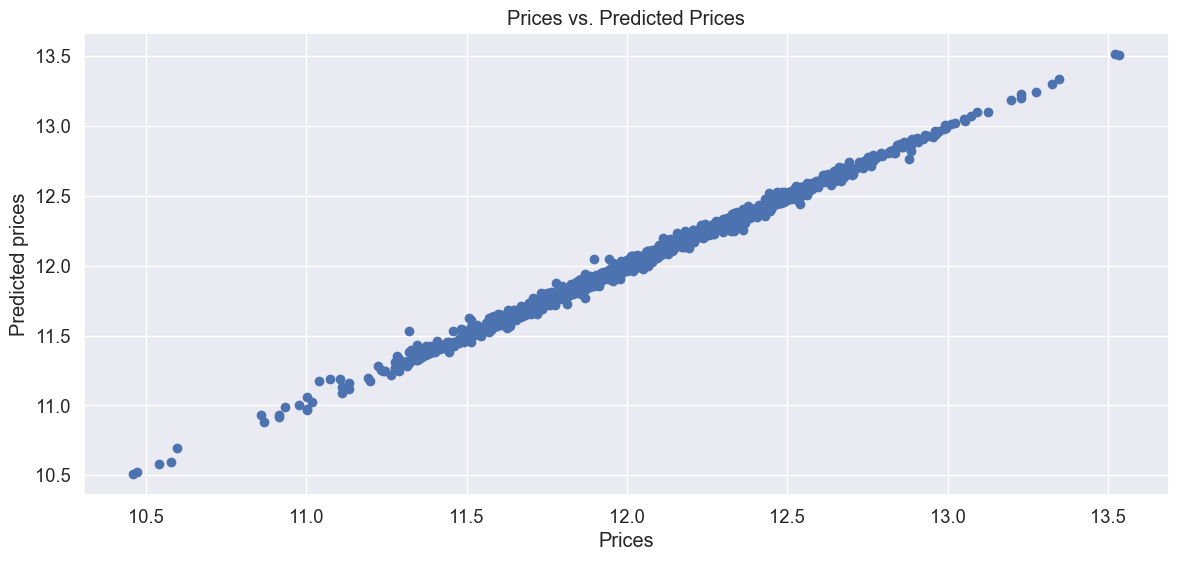

In [78]:
plt.figure(figsize=(14,6))
plt.scatter(y_train, y_train_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs. Predicted Prices")
plt.show()

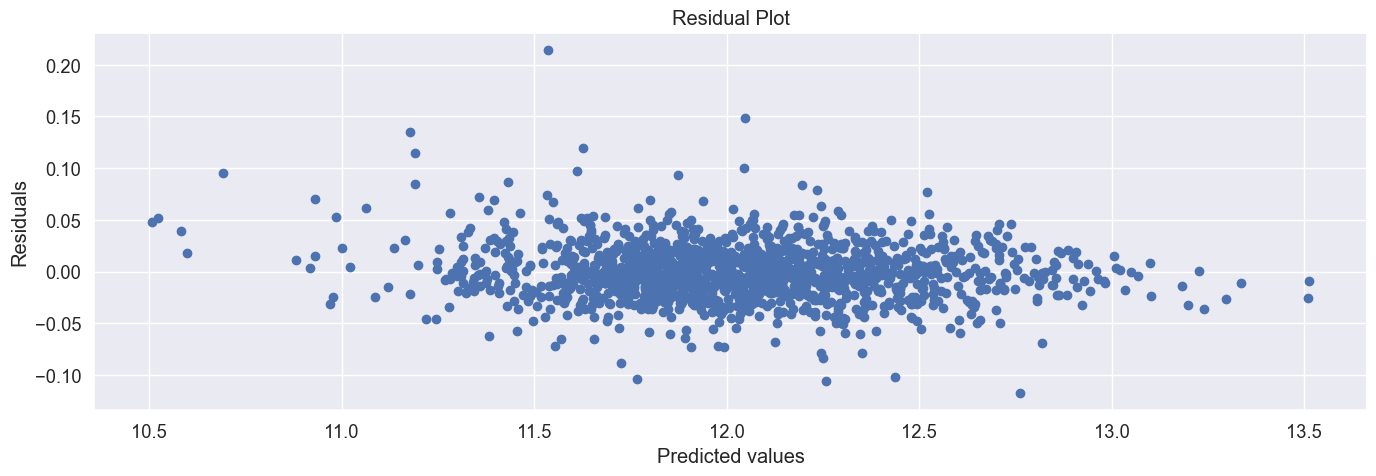

In [79]:
plt.figure(figsize=(14,5))
plt.scatter(y_train_pred,y_train_pred - y_train)
plt.title("Residual Plot")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.tight_layout()

In [80]:
from mlxtend.regressor import StackingCVRegressor

In [81]:
lasso_model = make_pipeline(RobustScaler(), 
                            LassoCV(max_iter= 10000000, alphas = [0.0005],random_state = 42, cv=5))

elasticnet_model = make_pipeline(RobustScaler(),
                                 ElasticNetCV(max_iter=10000000, alphas=[0.0005], cv=5, l1_ratio=0.9))

lgbm_model = make_pipeline(RobustScaler(),
                           lgb.LGBMRegressor(objective='regression',num_leaves=5,
                                             learning_rate=0.05, n_estimators=4000,
                                             max_bin = 55, bagging_fraction = 0.8,
                                             bagging_freq = 5, feature_fraction = 0.23,
                                             feature_fraction_seed = 9, bagging_seed=9,
                                             min_data_in_leaf = 6, 
                                             min_sum_hessian_in_leaf = 11))

xgboost_model = make_pipeline(RobustScaler(),
                              xgb.XGBRegressor(learning_rate = 0.01, n_estimators=3400,
                                               max_depth=3,min_child_weight=0 ,
                                               gamma=0, subsample=0.7,colsample_bytree=0.7,
                                               objective= 'reg:linear',nthread=4,
                                               scale_pos_weight=1,seed=27, reg_alpha=0.00006))

stack_regressor = StackingCVRegressor(regressors=(lasso_model, elasticnet_model, xgboost_model, lgbm_model),
                                      meta_regressor=xgboost_model, use_features_in_secondary=True)

In [82]:
stack_model = stack_regressor.fit(np.array(X_train),  np.array(y_train))

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.23, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.23, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightG

In [83]:
stack_gen_pred = stack_model.predict(X_test)
lgbm_pred = lgb_model.predict(X_test)
lasso_pred = ls_model.predict(X_test)
en_pred = en_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
gb_pred = gb_model.predict(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.23, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM

In [84]:
error = pd.DataFrame({'Models': ['Linear Regression','Lasso Model','Gradient Boosting Regressor','XGB Regressor','Elastic Net','Light GBM'],
                     'RMSE':[rmse_lr,rmse_lasso,rmse_gb,rmse_xgb,rmse_en,rmse_lgb]})
error.sort_values(by='RMSE',ascending =False)

,Models,RMSE
0,Linear Regression,0.16004
4,Elastic Net,0.13432
1,Lasso Model,0.13370
3,XGB Regressor,0.11800
2,Gradient Boosting Regressor,0.11782
5,Light GBM,0.02737


In [85]:
stack_preds = ((0.1*xgb_pred) + (0.075*gb_pred) + (0.4*lgbm_pred) + (0.4*stack_gen_pred) +(0.025*en_pred) ) 

In [86]:
stack_preds

array([11.744736  , 11.98532097, 12.15829005, ..., 12.0044217 ,
       11.66139031, 12.24339568])

In [87]:
final_pred = np.expm1(stack_preds)

In [88]:
sub = pd.read_csv('sample_submission.csv')

In [89]:
sub['SalePrice'] = final_pred
sub.head()

,Id,SalePrice
0,1461,126087.081631
1,1462,160382.157789
2,1463,190667.205702
3,1464,197226.363375
4,1465,183151.215400


In [90]:
sub.to_csv('submission.csv',index= False)